# Solving an inverse problem

In [1]:
%load_ext tensorboard

In [2]:
import numpy as np
import torch
import tensorboard, datetime
import matplotlib.pyplot as plt
from torch import nn
%matplotlib inline

## PDE

$\frac{\partial^2 u}{\partial x^2} = f(x) \text{ for } x \in (0,1)$

$u(0) = u(1) = 0$

$f(x)$ is unknown, but we are given training samples $\{x_i,u_i\}$

## Training data

In [3]:
def u_true(x):
    return (1/48)*(8*x*(x**2 - 1) - (3/np.pi**2)*np.sin(4*np.pi*x))

Text(0, 0.5, 'y')

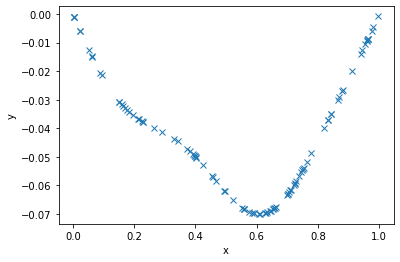

In [4]:
x_train = np.random.rand(100)
u_train = u_true(x_train)
plt.plot(x_train, u_train, 'x')
plt.xlabel('x')
plt.ylabel('y')

In [5]:
class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=2):
        super().__init__()
        
        self.layer_first = nn.Linear(1, nn_width)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 2)
        
    def forward(self, x):
        xt = x
        activation = nn.Tanh()
        u = activation(self.layer_first(xt))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        u = self.layer_last(u)
        return u

In [6]:
torch.manual_seed(23939)
model = ffnn(15, 2)

lr = 0.001
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 50000
loss_history = []

## Loss = MSE(u - u_i) + MSE(r_i)
def loss_function(model, x, u_true): 
    output = model(x)
    u = output[:, 0][:, None]
    f = output[:, 1][:, None]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(x), create_graph=True, retain_graph=True)[0]
    loss_bc1 = model(torch.zeros_like(u))
    loss_bc2 = model(torch.ones_like(u))
    loss = torch.pow(u_xx-f, 2).mean() + 1000* torch.pow(u-u_true, 2).mean() + loss_bc1.pow(2).mean() + loss_bc2.pow(2).mean()
    return loss


In [7]:
x = torch.tensor(x_train.reshape(100, 1), requires_grad=True, dtype = torch.float32)
u = torch.tensor(u_train.reshape(100, 1), dtype = torch.float32)

## Task

Use a PINN to find $u(x)$ and $f(x)$

In [8]:
for i in range(n_epochs):
    loss = loss_function(model, x, u)
    opt.zero_grad()
    loss_history.append(loss.item())
    
    loss.backward()
    opt.step()

    if i % 1000 == 0:
        print(f'epoch {i}, loss = {loss}')

epoch 0, loss = 127.74853515625
epoch 1000, loss = 0.19361940026283264
epoch 2000, loss = 0.08876048773527145
epoch 3000, loss = 0.030761385336518288
epoch 4000, loss = 0.020784279331564903
epoch 5000, loss = 0.01292929146438837
epoch 6000, loss = 0.011935261078178883
epoch 7000, loss = 0.011120995506644249
epoch 8000, loss = 0.010670346207916737
epoch 9000, loss = 0.010657153092324734
epoch 10000, loss = 0.01035380270332098
epoch 11000, loss = 0.010287000797688961
epoch 12000, loss = 0.010231821797788143
epoch 13000, loss = 0.010175833478569984
epoch 14000, loss = 0.010100586339831352
epoch 15000, loss = 0.009966244921088219
epoch 16000, loss = 0.009619418531656265
epoch 17000, loss = 0.008835259824991226
epoch 18000, loss = 0.007540605962276459
epoch 19000, loss = 0.004509606398642063
epoch 20000, loss = 0.002039112849161029
epoch 21000, loss = 0.0012278221547603607
epoch 22000, loss = 0.0008977031684480608
epoch 23000, loss = 0.0007107197889126837
epoch 24000, loss = 0.0005721670459

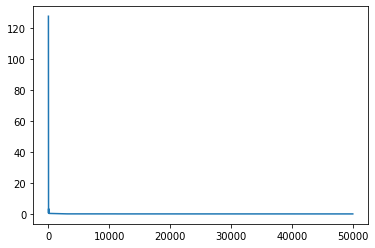

In [9]:
plt.plot(loss_history)

Text(0, 0.5, 'y')

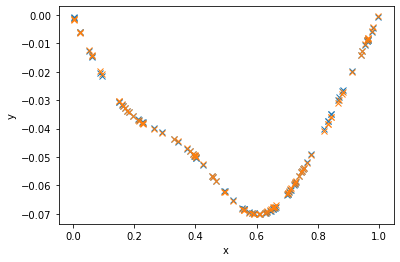

In [10]:
x_ = x.detach().numpy()
y_ = model(x)[:, 0].detach().numpy()
%matplotlib inline
plt.plot(x_train, u_train, 'x', label = "org")
plt.plot(x_train, y_, 'x', label = "pred")
plt.xlabel('x')
plt.ylabel('y')

<function matplotlib.pyplot.show(*args, **kw)>

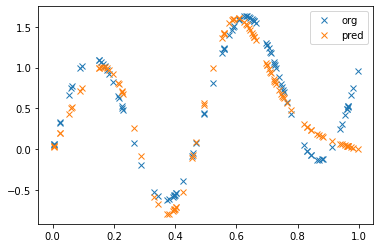

In [13]:
y_1 = model(x)[:, 1].detach().numpy()
def f_true(x):
    return (1/48)*(48*x + (3/np.pi**2)*((4*np.pi)**2)*np.sin(4*np.pi*x))
f_true = f_true(x_train)
plt.plot(x_train, f_true, 'x', label = "org")
plt.plot(x_train, y_1, 'x', label = "pred")
plt.legend()
plt.show